In [4]:
from dataloader import AmazonDataset
import models
from models import DistMulti, TransE
from training import TrainIterater
from evaluate import Evaluater

import optuna
import numpy as np
import pickle
import time

import torch
from importlib import reload

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# ハイパラ
# 
# embed_dim
# batch_size
# weight_decay, lr, warmup, lr_decay_every, lr_decay_rate
# kg embed model
model_name = 'TransE'
dataset = AmazonDataset('./data', model_name='TransE')
def time_since(runtime):
    mi = int(runtime / 60)
    sec = int(runtime - mi * 60)
    return (mi, sec)

def objective(trial):
    start = time.time()
    
    relation_size = len(set(list(dataset.triplet_df['relation'].values)))
    entity_size = len(dataset.entity_list)
    embedding_dim = trial.suggest_discrete_uniform('embedding_dim', 16, 128, 16)
    model = TransE(int(embedding_dim), relation_size, entity_size).to(device)
    
    batch_size = trial.suggest_int('batch_size', 128, 512, 128)
    iterater = TrainIterater(batch_size=int(batch_size), model_name=model_name)
    
    lr= trial.suggest_loguniform('lr', 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    warmup = trial.suggest_int('warmup', 100, 500)
    #warmup = trial.suggest_int('warmup', 1, 5)
    lr_decay_every = trial.suggest_int('lr_decay_every', 1, 10)
    lr_decay_rate = trial.suggest_uniform('lr_decay_rate', 0.5, 1)
    
    score =iterater.iterate_epoch(model, lr=lr, epoch=3000, weight_decay=weight_decay, warmup=warmup,
                           lr_decay_rate=lr_decay_rate, lr_decay_every=lr_decay_every, eval_every=100)
    
    mi, sec = time_since(time.time() - start)
    print('{}m{}sec'.format(mi, sec))
    
    return -1 * score

epoch: 99  precision: 0.06776298046653437
epoch: 199  precision: 0.12078563408430652
epoch: 299  precision: 0.14135575131809058
epoch: 399  precision: 0.141543488750726
epoch: 499  precision: 0.141543488750726
epoch: 599  precision: 0.141543488750726
epoch: 699  precision: 0.141543488750726
epoch: 799  precision: 0.141543488750726
epoch: 899  precision: 0.141543488750726
epoch: 999  precision: 0.141543488750726
epoch: 1099  precision: 0.141543488750726
epoch: 1199  precision: 0.141543488750726
epoch: 1299  precision: 0.141543488750726
epoch: 1399  precision: 0.141543488750726
epoch: 1499  precision: 0.141543488750726
epoch: 1599  precision: 0.141543488750726
epoch: 1699  precision: 0.141543488750726
epoch: 1799  precision: 0.141543488750726
epoch: 1899  precision: 0.141543488750726
epoch: 1999  precision: 0.141543488750726
epoch: 2099  precision: 0.141543488750726
epoch: 2199  precision: 0.141543488750726
epoch: 2299  precision: 0.141543488750726
epoch: 2399  precision: 0.1415434887507

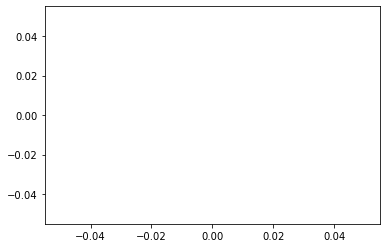

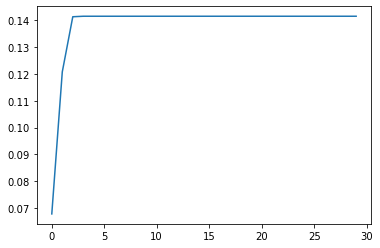

26m1sec


[I 2020-07-05 11:58:30,405] Finished trial#0 with value: -0.141543488750726 with parameters: {'embedding_dim': 128.0, 'batch_size': 512, 'lr': 0.0001861460829576727, 'weight_decay': 1.7487030833598665e-05, 'warmup': 265, 'lr_decay_every': 3, 'lr_decay_rate': 0.7788381372956257}. Best is trial#0 with value: -0.141543488750726.


epoch: 99  precision: 0.09677954028529732
epoch: 199  precision: 0.12955512075814368
epoch: 299  precision: 0.17352910505763028
epoch: 399  precision: 0.18982989457769037
epoch: 499  precision: 0.1903759471645593
epoch: 599  precision: 0.19042895538083282
epoch: 699  precision: 0.19042895538083282
epoch: 799  precision: 0.19042895538083282


In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=20)

In [ ]:
df = study.trials_dataframe() # pandasのDataFrame形式
df.to_csv('./hyparams_result.csv')

In [ ]:
# save best params 
with open('best_param.pickle', 'wb') as f:
    pickle.dump(study.best_params, f)

In [9]:
study.best_params

{'embedding_dim': 48.0,
 'batch_size': 256,
 'lr': 0.00027575703280897554,
 'weight_decay': 0.008211142725366551,
 'warmup': 5,
 'lr_decay_every': 8,
 'lr_decay_rate': 0.6785466714298021}